In [1]:
'''Trains infoGAN on MNIST using Keras
This version of infoGAN is similar to DCGAN. The difference mainly
is that the z-vector of geneerator is conditioned by a one-hot label
to produce specific fake images. The discriminator is trained to
discriminate real from fake images and predict the corresponding
one-hot labels.
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Chen, Xi, et al. "Infogan: Interpretable representation learning by
information maximizing generative adversarial nets." 
Advances in Neural Information Processing Systems. 2016.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Input
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import load_model
from keras import backend as K

import numpy as np
import argparse

import sys
sys.path.append("..")
from lib import gan

# from ..lib import gan

def train(models, data, params):
    """Train the Discriminator and Adversarial networks
    Alternately train discriminator and adversarial networks by batch.
    Discriminator is trained first with real and fake images,
    corresponding one-hot labels and continuous codes.
    Adversarial is trained next with fake images pretending to be real,
    corresponding one-hot labels and continous codes.
    Generate sample images per save_interval.
    # Arguments
        models (Models): Generator, Discriminator, Adversarial models
        data (tuple): x_train, y_train data
        params (tuple): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    
    # images and their one-hot labels
    x_train, y_train = data
    
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    
    # the generator image is saved every 500 steps
    save_interval = 500
    
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    
    # random class labels and codes
    noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    noise_code1 = np.random.normal(scale=0.5, size=[16, 1])
    noise_code2 = np.random.normal(scale=0.5, size=[16, 1])
    
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_label, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images and corresponding labels from dataset 
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        # random codes for real images
        real_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
        real_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        fake_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        inputs = [noise, fake_labels, fake_code1, fake_code2]
        fake_images = generator.predict(inputs)

        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        codes1 = np.concatenate((real_code1, fake_code1))
        codes2 = np.concatenate((real_code2, fake_code2))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0

        # train discriminator network, log the loss and label accuracy
        outputs = [y, labels, codes1, codes2]
        # metrics = ['loss', 'activation_1_loss', 'label_loss',
        # 'code1_loss', 'code2_loss', 'activation_1_acc',
        # 'label_acc', 'code1_acc', 'code2_acc']
        # from discriminator.metrics_names
        metrics = discriminator.train_on_batch(x, outputs)
        fmt = "%d: [discriminator loss: %f, label_acc: %f]"
        log = fmt % (i, metrics[0], metrics[6])

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0 and
        # corresponding one-hot label or class + random codes
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        fake_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        # label fake images as real
        y = np.ones([batch_size, 1])

        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and label accuracy
        inputs = [noise, fake_labels, fake_code1, fake_code2]
        outputs = [y, fake_labels, fake_code1, fake_code2]
        metrics  = adversarial.train_on_batch(inputs, outputs)
        fmt = "%s [adversarial loss: %f, label_acc: %f]"
        log = fmt % (log, metrics[0], metrics[6])

        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False
    
            # plot generator images on a periodic basis
            gan.plot_images(generator,
                            noise_input=noise_input,
                            noise_label=noise_label,
                            noise_codes=[noise_code1, noise_code2],
                            show=show,
                            step=(i + 1),
                            model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for
    # future MNIST digit generation
    generator.save(model_name + ".h5")


def mi_loss(c, q_of_c_given_x):
    """ Mutual information, Equation 5 in [2] , assuming H(c) is constant"""
    # mi_loss = -c * log(Q(c|x))
    return K.mean(-K.sum(K.log(q_of_c_given_x + K.epsilon()) * c, axis=1))


def build_and_train_models(latent_size=100):
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    # train labels
    num_labels = len(np.unique(y_train))
    y_train = to_categorical(y_train)

    model_name = "infogan_mnist"
    # network parameters
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )
    code_shape = (1, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    # call discriminator builder with 4 outputs: source, label, and 2 codes
    discriminator = gan.discriminator(inputs,
                                      num_labels=num_labels,
                                      num_codes=2)
    # [1] uses Adam, but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    # loss functions: 1) probability image is real (binary crossentropy)
    # 2) categorical cross entropy image label,
    # 3) and 4) mutual information loss
    loss = ['binary_crossentropy', 'categorical_crossentropy', mi_loss, mi_loss]
    # lamda or mi_loss weight is 0.5
    loss_weights = [1.0, 1.0, 0.5, 0.5]
    discriminator.compile(loss=loss,
                          loss_weights=loss_weights,
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    labels = Input(shape=label_shape, name='labels')
    code1 = Input(shape=code_shape, name="code1")
    code2 = Input(shape=code_shape, name="code2")
    # call generator with inputs, 
    # labels and codes as total inputs to generator
    generator = gan.generator(inputs,
                              image_size,
                              labels=labels,
                              codes=[code1, code2])
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    discriminator.trainable = False
    # total inputs = noise code, labels, and codes
    inputs = [inputs, labels, code1, code2]
    adversarial = Model(inputs,
                        discriminator(generator(inputs)),
                        name=model_name)
    # same loss as discriminator
    adversarial.compile(loss=loss,
                        loss_weights=loss_weights,
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


def test_generator(generator, params, latent_size=100):
    label, code1, code2, p1, p2 = params
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    step = 0
    if label is None:
        num_labels = 10
        noise_label = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_label = np.zeros((16, 10))
        noise_label[:,label] = 1
        step = label

    if code1 is None:
        noise_code1 = np.random.normal(scale=0.5, size=[16, 1])
    else:
        if p1:
            a = np.linspace(-2, 2, 16)
            a = np.reshape(a, [16, 1])
            noise_code1 = np.ones((16, 1)) * a
        else:
            noise_code1 = np.ones((16, 1)) * code1
        print(noise_code1)

    if code2 is None:
        noise_code2 = np.random.normal(scale=0.5, size=[16, 1])
    else:
        if p2:
            a = np.linspace(-2, 2, 16)
            a = np.reshape(a, [16, 1])
            noise_code2 = np.ones((16, 1)) * a
        else:
            noise_code2 = np.ones((16, 1)) * code2
        print(noise_code2)

    gan.plot_images(generator,
                    noise_input=noise_input,
                    noise_label=noise_label,
                    noise_codes=[noise_code1, noise_code2],
                    show=True,
                    step=step,
                    model_name="test_outputs")

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[[-2.        ]
 [-1.73333333]
 [-1.46666667]
 [-1.2       ]
 [-0.93333333]
 [-0.66666667]
 [-0.4       ]
 [-0.13333333]
 [ 0.13333333]
 [ 0.4       ]
 [ 0.66666667]
 [ 0.93333333]
 [ 1.2       ]
 [ 1.46666667]
 [ 1.73333333]
 [ 2.        ]]
[[-2.        ]
 [-1.73333333]
 [-1.46666667]
 [-1.2       ]
 [-0.93333333]
 [-0.66666667]
 [-0.4       ]
 [-0.13333333]
 [ 0.13333333]
 [ 0.4       ]
 [ 0.66666667]
 [ 0.93333333]
 [ 1.2       ]
 [ 1.46666667]
 [ 1.73333333]
 [ 2.        ]]


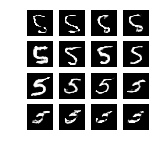

In [15]:
generator = load_model('infogan_mnist.h5')
label = 5
code1 = 0
code2 = 0
p1 = -2
p2 = 2
params = (label, code1, code2, p1, p2)
test_generator(generator, params, latent_size=62)